# Setup

In [8]:
# imports
import pandas as pd
import seaborn as sns

In [18]:
# constants
RELEASED_VERSIONS = ["2.0.0", "2.0.1",
                     "2.1.0", "2.1.1", "2.2.0",
                     "2.3.0", "2.3.1", "2.3.2", "2.3.3", "2.3.4", "2.3.5", "2.3.6", "2.3.7", "2.3.8", "2.3.9",
                     "3.0.0", "3.1.0", "3.1.1", "3.1.2", "3.1.3"]

INPUT_DIR = "../../data/input/"
OUTPUT_DIR = "../../data/output/"

# Load data

We take a look at the raw metrics data to know how to process it 

In [23]:
df = pd.read_csv(INPUT_DIR + "hive-metrics-v2/2.0.0.csv")
df.head()

,Kind,Name,File,AltAvgLineBlank,AltAvgLineCode,AltAvgLineComment,AltCountLineBlank,AltCountLineCode,AltCountLineComment,AvgCyclomatic,...,MaxInheritanceTree,MaxNesting,MinEssentialKnots,PercentLackOfCohesion,PercentLackOfCohesionModified,RatioCommentToCode,SumCyclomatic,SumCyclomaticModified,SumCyclomaticStrict,SumEssential
0,Class,Apache::Hadoop::Hive::AbortTxnRequest,hive\metastore\src\gen\thrift\gen-cpp\hive_met...,0.0,7.0,0.0,16.0,88.0,0.0,1.0,...,0.0,3.0,NaN,27.0,NaN,0.0,16.0,16.0,16.0,12.0
1,Public Function,Apache::Hadoop::Hive::AbortTxnRequest::AbortTx...,hive\metastore\src\gen\thrift\gen-cpp\hive_met...,NaN,NaN,NaN,0.0,3.0,0.0,NaN,...,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,Public Function,Apache::Hadoop::Hive::AbortTxnRequest::AbortTx...,hive\metastore\src\gen\thrift\gen-cpp\hive_met...,NaN,NaN,NaN,0.0,2.0,0.0,NaN,...,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
3,Public Function,Apache::Hadoop::Hive::AbortTxnRequest::__set_t...,hive\metastore\src\gen\thrift\gen-cpp\hive_met...,NaN,NaN,NaN,0.0,3.0,0.0,NaN,...,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,Public Const Function,Apache::Hadoop::Hive::AbortTxnRequest::operator!=,hive\metastore\src\gen\thrift\gen-cpp\hive_met...,NaN,NaN,NaN,0.0,3.0,0.0,NaN,...,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN


We can see that we have metrics for not only files but also for packages, classes, and functions. Also, there are a lot more metrics than we want.
Therefore, we need to select precisely what we want from the dataset.

Below we can observe that classes' metrics don't have any value for files.

In [4]:
classes_metrics_cols = ["Name", "CountClassBase", "CountClassCoupled", "CountClassDerived", "MaxInheritanceTree", "PercentLackOfCohesion"]
df.loc[df["Kind"] == "File"][classes_metrics_cols].describe().loc["count"]

CountClassBase           0.0
CountClassCoupled        0.0
CountClassDerived        0.0
MaxInheritanceTree       0.0
PercentLackOfCohesion    0.0
Name: count, dtype: float64

Same for methods' metrics

In [5]:
methods_metrics_cols = ["Name", "CountInput", "CountClassCoupled", "CountClassDerived", "MaxInheritanceTree", "PercentLackOfCohesion"]
df.loc[df["Kind"] == "File"][methods_metrics_cols].describe().loc["count"]

CountInput               0.0
CountClassCoupled        0.0
CountClassDerived        0.0
MaxInheritanceTree       0.0
PercentLackOfCohesion    0.0
Name: count, dtype: float64

### Metrics selection

We therefore choose to only collect files' metrics as we are trying to predict bugs at files level.

In [6]:
metrics_cols = ["Name", "AvgCyclomatic", "AvgCyclomaticModified", "AvgCyclomaticStrict", "AvgEssential", "AvgLine", "AvgLineBlank", "AvgLineCode", 
    "AvgLineComment", "CountDeclClass", "CountDeclClassMethod", "CountDeclClassVariable", "CountDeclFunction", "CountDeclInstanceMethod",
    "CountDeclInstanceVariable", "CountDeclMethod", "CountDeclMethodDefault", "CountDeclMethodPrivate", "CountDeclMethodProtected",
    "CountDeclMethodPublic", "CountLine", "CountLineBlank", "CountLineCode", "CountLineCodeDecl", "CountLineCodeExe", "CountLineComment", 
    "CountSemicolon", "CountStmt", "CountStmtDecl", "CountStmtExe", "MaxCyclomatic", "MaxCyclomaticModified", "MaxCyclomaticStrict", 
    "RatioCommentToCode", "SumCyclomatic", "SumCyclomaticModified", "SumCyclomaticStrict", "SumEssential"]

data = df.loc[df["Kind"] == "File"][metrics_cols]
data.describe()

,AvgCyclomatic,AvgCyclomaticModified,AvgCyclomaticStrict,AvgEssential,AvgLine,AvgLineBlank,AvgLineCode,AvgLineComment,CountDeclClass,CountDeclClassMethod,...,CountStmtDecl,CountStmtExe,MaxCyclomatic,MaxCyclomaticModified,MaxCyclomaticStrict,RatioCommentToCode,SumCyclomatic,SumCyclomaticModified,SumCyclomaticStrict,SumEssential
count,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4953.000000,...,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000
mean,1.755008,1.631410,1.896835,1.028646,12.165264,0.654647,10.082933,1.047877,2.701723,1.792449,...,65.978566,112.604768,5.886819,5.330128,7.014824,0.877326,43.287861,40.936498,46.558093,25.011218
std,1.878251,1.484832,2.077340,0.728791,13.920479,2.024822,11.074217,2.309787,35.769781,18.347462,...,485.997380,1252.434005,8.452574,7.227726,10.928310,2.681480,539.986280,510.093969,585.422186,324.414761
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,4.000000,0.000000,4.000000,0.000000,1.000000,0.000000,...,12.000000,7.000000,1.000000,1.000000,1.000000,0.210000,4.000000,4.000000,4.000000,3.000000
50%,1.000000,1.000000,1.000000,1.000000,8.000000,0.000000,7.000000,0.000000,1.000000,0.000000,...,26.000000,25.000000,3.000000,3.000000,3.000000,0.410000,10.000000,10.000000,11.000000,7.000000
75%,2.000000,2.000000,2.000000,1.000000,15.000000,1.000000,13.000000,1.000000,2.000000,1.000000,...,60.000000,78.000000,7.000000,7.000000,9.000000,0.880000,28.000000,27.000000,30.000000,16.000000
max,35.000000,17.000000,35.000000,13.000000,354.000000,66.000000,260.000000,38.000000,2409.000000,902.000000,...,29959.000000,76450.000000,145.000000,96.000000,152.000000,144.000000,35520.000000,33530.000000,38848.000000,21642.000000


In [7]:
data.insert(1, "Version", "2.0.0")
data.head()

,Name,Version,AvgCyclomatic,AvgCyclomaticModified,AvgCyclomaticStrict,AvgEssential,AvgLine,AvgLineBlank,AvgLineCode,AvgLineComment,...,CountStmtDecl,CountStmtExe,MaxCyclomatic,MaxCyclomaticModified,MaxCyclomaticStrict,RatioCommentToCode,SumCyclomatic,SumCyclomaticModified,SumCyclomaticStrict,SumEssential
0,ACLConfigurationParser.java,2.0.0,2.0,2.0,3.0,2.0,10.0,0.0,10.0,0.0,...,37.0,58.0,11.0,11.0,13.0,0.16,29.0,29.0,32.0,22.0
1,AMReporter.java,2.0.0,1.0,1.0,2.0,1.0,11.0,0.0,10.0,0.0,...,135.0,155.0,7.0,7.0,9.0,0.13,65.0,65.0,68.0,36.0
2,ASTBuilder.java,2.0.0,5.0,1.0,5.0,1.0,16.0,0.0,14.0,0.0,...,60.0,120.0,64.0,9.0,64.0,0.09,90.0,32.0,90.0,22.0
3,ASTConverter.java,2.0.0,3.0,3.0,4.0,1.0,18.0,1.0,15.0,1.0,...,249.0,345.0,21.0,21.0,23.0,0.15,144.0,144.0,157.0,44.0
4,ASTErrorNode.java,2.0.0,1.0,1.0,1.0,1.0,2.0,0.0,2.0,0.0,...,13.0,5.0,1.0,1.0,1.0,0.95,5.0,5.0,5.0,5.0


We have a proper dataset to work on. 

Now, let us replicate this process on all versions of files.

In [8]:
for version in RELEASED_VERSIONS:
    df = pd.read_csv(INPUT_DIR + f"hive-metrics-{version}.csv")
    df = df.loc[df["Kind"] == "File"][metrics_cols]
    df.insert(1, "Version", version)
    df.to_csv(OUTPUT_DIR + f"hive-files-metrics-{version}.csv", index=False)
    

We can now concatenate all the generated files above, to have the unlabeled dataset.

In [9]:
versions_data = []

for version in RELEASED_VERSIONS:
    df = pd.read_csv(OUTPUT_DIR + f"hive-files-metrics-{version}.csv")
    versions_data.append(df)

unlabeled_data = pd.concat(versions_data, ignore_index=True)
unlabeled_data = unlabeled_data.rename(columns={"Name": "File"})
unlabeled_data.to_csv(OUTPUT_DIR + f"hive-unlabeled-data.csv", index=False)
unlabeled_data

,File,Version,AvgCyclomatic,AvgCyclomaticModified,AvgCyclomaticStrict,AvgEssential,AvgLine,AvgLineBlank,AvgLineCode,AvgLineComment,...,CountStmtDecl,CountStmtExe,MaxCyclomatic,MaxCyclomaticModified,MaxCyclomaticStrict,RatioCommentToCode,SumCyclomatic,SumCyclomaticModified,SumCyclomaticStrict,SumEssential
0,ACLConfigurationParser.java,2.0.0,2.0,2.0,3.0,2.0,10.0,0.0,10.0,0.0,...,37.0,58.0,11.0,11.0,13.0,0.16,29.0,29.0,32.0,22.0
1,AMReporter.java,2.0.0,1.0,1.0,2.0,1.0,11.0,0.0,10.0,0.0,...,135.0,155.0,7.0,7.0,9.0,0.13,65.0,65.0,68.0,36.0
2,ASTBuilder.java,2.0.0,5.0,1.0,5.0,1.0,16.0,0.0,14.0,0.0,...,60.0,120.0,64.0,9.0,64.0,0.09,90.0,32.0,90.0,22.0
3,ASTConverter.java,2.0.0,3.0,3.0,4.0,1.0,18.0,1.0,15.0,1.0,...,249.0,345.0,21.0,21.0,23.0,0.15,144.0,144.0,157.0,44.0
4,ASTErrorNode.java,2.0.0,1.0,1.0,1.0,1.0,2.0,0.0,2.0,0.0,...,13.0,5.0,1.0,1.0,1.0,0.95,5.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99835,testthrift_types.h,3.1.3,1.0,1.0,1.0,1.0,4.0,0.0,4.0,0.0,...,45.0,16.0,4.0,4.0,4.0,0.07,14.0,14.0,14.0,13.0
99836,thrift_grammar.java,3.1.3,9.0,7.0,9.0,3.0,44.0,0.0,42.0,1.0,...,223.0,1550.0,32.0,23.0,32.0,0.03,675.0,537.0,677.0,244.0
99837,thrift_grammarConstants.java,3.1.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,56.0,0.0,0.0,0.0,0.0,0.81,0.0,0.0,0.0,0.0
99838,thrift_grammarTokenManager.java,3.1.3,13.0,7.0,14.0,10.0,41.0,0.0,41.0,0.0,...,76.0,870.0,145.0,92.0,152.0,0.01,502.0,272.0,512.0,380.0


### Adding features 

Let:
- all files with the *.java* extention be labeled as **java** files,  
- all files with the *.cpp* extention be labeled as **cpp** files, and  
- all files with the *.h* or *.hpp* extention be labeled as **header** files.

In [10]:
unlabeled_data["FileType"] = pd.NA
unlabeled_data.loc[unlabeled_data["File"].str.endswith(".java"), "FileType"] = "java"
unlabeled_data.loc[unlabeled_data["File"].str.endswith(".cpp"), "FileType"] = "cpp"
unlabeled_data.loc[unlabeled_data["File"].str.endswith(".hpp"), "FileType"] = "header"
unlabeled_data.loc[unlabeled_data["File"].str.endswith(".h"), "FileType"] = "header"

unlabeled_data

,File,Version,AvgCyclomatic,AvgCyclomaticModified,AvgCyclomaticStrict,AvgEssential,AvgLine,AvgLineBlank,AvgLineCode,AvgLineComment,...,CountStmtExe,MaxCyclomatic,MaxCyclomaticModified,MaxCyclomaticStrict,RatioCommentToCode,SumCyclomatic,SumCyclomaticModified,SumCyclomaticStrict,SumEssential,FileType
0,ACLConfigurationParser.java,2.0.0,2.0,2.0,3.0,2.0,10.0,0.0,10.0,0.0,...,58.0,11.0,11.0,13.0,0.16,29.0,29.0,32.0,22.0,java
1,AMReporter.java,2.0.0,1.0,1.0,2.0,1.0,11.0,0.0,10.0,0.0,...,155.0,7.0,7.0,9.0,0.13,65.0,65.0,68.0,36.0,java
2,ASTBuilder.java,2.0.0,5.0,1.0,5.0,1.0,16.0,0.0,14.0,0.0,...,120.0,64.0,9.0,64.0,0.09,90.0,32.0,90.0,22.0,java
3,ASTConverter.java,2.0.0,3.0,3.0,4.0,1.0,18.0,1.0,15.0,1.0,...,345.0,21.0,21.0,23.0,0.15,144.0,144.0,157.0,44.0,java
4,ASTErrorNode.java,2.0.0,1.0,1.0,1.0,1.0,2.0,0.0,2.0,0.0,...,5.0,1.0,1.0,1.0,0.95,5.0,5.0,5.0,5.0,java
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99835,testthrift_types.h,3.1.3,1.0,1.0,1.0,1.0,4.0,0.0,4.0,0.0,...,16.0,4.0,4.0,4.0,0.07,14.0,14.0,14.0,13.0,header
99836,thrift_grammar.java,3.1.3,9.0,7.0,9.0,3.0,44.0,0.0,42.0,1.0,...,1550.0,32.0,23.0,32.0,0.03,675.0,537.0,677.0,244.0,java
99837,thrift_grammarConstants.java,3.1.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.81,0.0,0.0,0.0,0.0,java
99838,thrift_grammarTokenManager.java,3.1.3,13.0,7.0,14.0,10.0,41.0,0.0,41.0,0.0,...,870.0,145.0,92.0,152.0,0.01,502.0,272.0,512.0,380.0,java


### Data labelling

We load labels

In [11]:
labels = pd.read_csv(OUTPUT_DIR + "hive-bugs-files.csv")
labels.head()

,IssueId,CommitId,File,Version
0,HIVE-10233,749b286867f314813de501efe9dca9d3c92fd219,HiveConf.java,2.0.0
1,HIVE-10233,749b286867f314813de501efe9dca9d3c92fd219,HashTableLoader.java,2.0.0
2,HIVE-10233,749b286867f314813de501efe9dca9d3c92fd219,MemoryDecider.java,2.0.0
3,HIVE-10233,749b286867f314813de501efe9dca9d3c92fd219,TezCompiler.java,2.0.0
4,HIVE-10233,749b286867f314813de501efe9dca9d3c92fd219,AbstractOperatorDesc.java,2.0.0


In [12]:
labels.shape

(1560, 4)

Let us add `Bug` column and set its value to 1 for all file/version in labels dataset

In [13]:
labels["Bug"] = 1

Merge unlabeled data to labels

In [14]:
dataset = pd.merge(left=unlabeled_data, right=labels, on=["File", "Version"], how="left")
dataset

,File,Version,AvgCyclomatic,AvgCyclomaticModified,AvgCyclomaticStrict,AvgEssential,AvgLine,AvgLineBlank,AvgLineCode,AvgLineComment,...,MaxCyclomaticStrict,RatioCommentToCode,SumCyclomatic,SumCyclomaticModified,SumCyclomaticStrict,SumEssential,FileType,IssueId,CommitId,Bug
0,ACLConfigurationParser.java,2.0.0,2.0,2.0,3.0,2.0,10.0,0.0,10.0,0.0,...,13.0,0.16,29.0,29.0,32.0,22.0,java,NaN,NaN,NaN
1,AMReporter.java,2.0.0,1.0,1.0,2.0,1.0,11.0,0.0,10.0,0.0,...,9.0,0.13,65.0,65.0,68.0,36.0,java,NaN,NaN,NaN
2,ASTBuilder.java,2.0.0,5.0,1.0,5.0,1.0,16.0,0.0,14.0,0.0,...,64.0,0.09,90.0,32.0,90.0,22.0,java,NaN,NaN,NaN
3,ASTConverter.java,2.0.0,3.0,3.0,4.0,1.0,18.0,1.0,15.0,1.0,...,23.0,0.15,144.0,144.0,157.0,44.0,java,NaN,NaN,NaN
4,ASTErrorNode.java,2.0.0,1.0,1.0,1.0,1.0,2.0,0.0,2.0,0.0,...,1.0,0.95,5.0,5.0,5.0,5.0,java,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100044,testthrift_types.h,3.1.3,1.0,1.0,1.0,1.0,4.0,0.0,4.0,0.0,...,4.0,0.07,14.0,14.0,14.0,13.0,header,NaN,NaN,NaN
100045,thrift_grammar.java,3.1.3,9.0,7.0,9.0,3.0,44.0,0.0,42.0,1.0,...,32.0,0.03,675.0,537.0,677.0,244.0,java,NaN,NaN,NaN
100046,thrift_grammarConstants.java,3.1.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.81,0.0,0.0,0.0,0.0,java,NaN,NaN,NaN
100047,thrift_grammarTokenManager.java,3.1.3,13.0,7.0,14.0,10.0,41.0,0.0,41.0,0.0,...,152.0,0.01,502.0,272.0,512.0,380.0,java,NaN,NaN,NaN


Remove duplicated data

In [15]:
dataset.drop_duplicates(keep="first", inplace=True)
dataset.shape

(99849, 43)

Remove unnecessary columns

In [16]:
dataset.drop(columns=["IssueId", "CommitId", "File", "Version"], inplace=True)
dataset["Bug"] = dataset["Bug"].fillna(0).astype(int)


In [17]:
dataset.to_csv(OUTPUT_DIR + "dataset.csv", index=False)
dataset

,AvgCyclomatic,AvgCyclomaticModified,AvgCyclomaticStrict,AvgEssential,AvgLine,AvgLineBlank,AvgLineCode,AvgLineComment,CountDeclClass,CountDeclClassMethod,...,MaxCyclomatic,MaxCyclomaticModified,MaxCyclomaticStrict,RatioCommentToCode,SumCyclomatic,SumCyclomaticModified,SumCyclomaticStrict,SumEssential,FileType,Bug
0,2.0,2.0,3.0,2.0,10.0,0.0,10.0,0.0,1.0,0.0,...,11.0,11.0,13.0,0.16,29.0,29.0,32.0,22.0,java,0
1,1.0,1.0,2.0,1.0,11.0,0.0,10.0,0.0,9.0,0.0,...,7.0,7.0,9.0,0.13,65.0,65.0,68.0,36.0,java,0
2,5.0,1.0,5.0,1.0,16.0,0.0,14.0,0.0,1.0,14.0,...,64.0,9.0,64.0,0.09,90.0,32.0,90.0,22.0,java,0
3,3.0,3.0,4.0,1.0,18.0,1.0,15.0,1.0,7.0,2.0,...,21.0,21.0,23.0,0.15,144.0,144.0,157.0,44.0,java,0
4,1.0,1.0,1.0,1.0,2.0,0.0,2.0,0.0,1.0,0.0,...,1.0,1.0,1.0,0.95,5.0,5.0,5.0,5.0,java,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100044,1.0,1.0,1.0,1.0,4.0,0.0,4.0,0.0,2.0,NaN,...,4.0,4.0,4.0,0.07,14.0,14.0,14.0,13.0,header,0
100045,9.0,7.0,9.0,3.0,44.0,0.0,42.0,1.0,1.0,5.0,...,32.0,23.0,32.0,0.03,675.0,537.0,677.0,244.0,java,0
100046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.81,0.0,0.0,0.0,0.0,java,0
100047,13.0,7.0,14.0,10.0,41.0,0.0,41.0,0.0,1.0,0.0,...,145.0,92.0,152.0,0.01,502.0,272.0,512.0,380.0,java,0


### Reload data

In [18]:
dataset = pd.read_csv(OUTPUT_DIR + "dataset.csv")
dataset

,AvgCyclomatic,AvgCyclomaticModified,AvgCyclomaticStrict,AvgEssential,AvgLine,AvgLineBlank,AvgLineCode,AvgLineComment,CountDeclClass,CountDeclClassMethod,...,MaxCyclomatic,MaxCyclomaticModified,MaxCyclomaticStrict,RatioCommentToCode,SumCyclomatic,SumCyclomaticModified,SumCyclomaticStrict,SumEssential,FileType,Bug
0,2.0,2.0,3.0,2.0,10.0,0.0,10.0,0.0,1.0,0.0,...,11.0,11.0,13.0,0.16,29.0,29.0,32.0,22.0,java,0
1,1.0,1.0,2.0,1.0,11.0,0.0,10.0,0.0,9.0,0.0,...,7.0,7.0,9.0,0.13,65.0,65.0,68.0,36.0,java,0
2,5.0,1.0,5.0,1.0,16.0,0.0,14.0,0.0,1.0,14.0,...,64.0,9.0,64.0,0.09,90.0,32.0,90.0,22.0,java,0
3,3.0,3.0,4.0,1.0,18.0,1.0,15.0,1.0,7.0,2.0,...,21.0,21.0,23.0,0.15,144.0,144.0,157.0,44.0,java,0
4,1.0,1.0,1.0,1.0,2.0,0.0,2.0,0.0,1.0,0.0,...,1.0,1.0,1.0,0.95,5.0,5.0,5.0,5.0,java,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99844,1.0,1.0,1.0,1.0,4.0,0.0,4.0,0.0,2.0,NaN,...,4.0,4.0,4.0,0.07,14.0,14.0,14.0,13.0,header,0
99845,9.0,7.0,9.0,3.0,44.0,0.0,42.0,1.0,1.0,5.0,...,32.0,23.0,32.0,0.03,675.0,537.0,677.0,244.0,java,0
99846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.81,0.0,0.0,0.0,0.0,java,0
99847,13.0,7.0,14.0,10.0,41.0,0.0,41.0,0.0,1.0,0.0,...,145.0,92.0,152.0,0.01,502.0,272.0,512.0,380.0,java,0


In [19]:
dataset.describe()

,AvgCyclomatic,AvgCyclomaticModified,AvgCyclomaticStrict,AvgEssential,AvgLine,AvgLineBlank,AvgLineCode,AvgLineComment,CountDeclClass,CountDeclClassMethod,...,CountStmtExe,MaxCyclomatic,MaxCyclomaticModified,MaxCyclomaticStrict,RatioCommentToCode,SumCyclomatic,SumCyclomaticModified,SumCyclomaticStrict,SumEssential,Bug
count,99849.000000,99849.000000,99849.000000,99849.000000,99849.000000,99849.000000,99849.000000,99849.000000,99849.000000,99069.000000,...,99849.000000,99849.000000,99849.000000,99849.000000,99849.000000,99849.000000,99849.000000,99849.000000,99849.000000,99849.000000
mean,1.759467,1.635660,1.902383,1.030226,12.199151,0.655640,10.109836,1.052770,2.742030,1.843927,...,115.839728,5.934421,5.375697,7.074523,0.860686,44.518122,42.116736,47.931537,25.572835,0.013440
std,1.878730,1.485605,2.078466,0.728199,13.923178,2.024877,11.074909,2.312847,36.568853,18.618618,...,1278.480721,8.535774,7.318328,11.034427,2.631156,552.257658,521.701816,599.041866,331.665821,0.115151
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,4.000000,0.000000,4.000000,0.000000,1.000000,0.000000,...,7.000000,1.000000,1.000000,1.000000,0.210000,4.000000,4.000000,4.000000,3.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,9.000000,0.000000,7.000000,0.000000,1.000000,0.000000,...,25.000000,3.000000,3.000000,3.000000,0.410000,10.000000,10.000000,11.000000,7.000000,0.000000
75%,2.000000,2.000000,2.000000,1.000000,15.000000,1.000000,13.000000,1.000000,2.000000,1.000000,...,79.000000,7.000000,7.000000,9.000000,0.880000,29.000000,27.000000,30.000000,16.000000,0.000000
max,35.000000,17.000000,35.000000,13.000000,354.000000,66.000000,260.000000,38.000000,2409.000000,902.000000,...,76450.000000,145.000000,96.000000,152.000000,144.000000,35520.000000,33530.000000,38848.000000,21642.000000,1.000000


<AxesSubplot:xlabel='Bug', ylabel='count'>

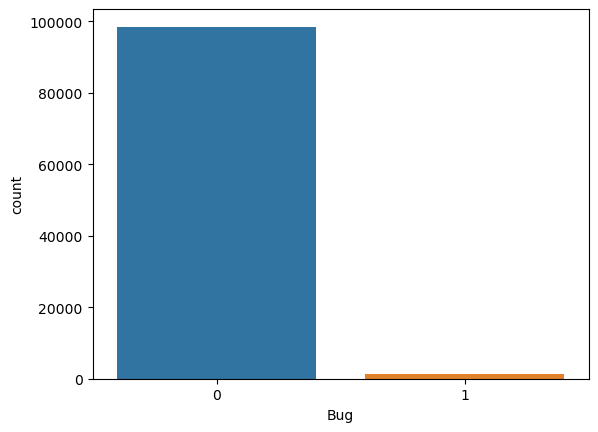

In [20]:
sns.countplot(dataset, x="Bug")

In [21]:
dataset.to_csv(OUTPUT_DIR + "dataset.csv", index=False)

# Preprocess data

### Correlation Matrix

In [22]:
dataset.corr()

,AvgCyclomatic,AvgCyclomaticModified,AvgCyclomaticStrict,AvgEssential,AvgLine,AvgLineBlank,AvgLineCode,AvgLineComment,CountDeclClass,CountDeclClassMethod,...,CountStmtExe,MaxCyclomatic,MaxCyclomaticModified,MaxCyclomaticStrict,RatioCommentToCode,SumCyclomatic,SumCyclomaticModified,SumCyclomaticStrict,SumEssential,Bug
AvgCyclomatic,1.000000,0.884656,0.979062,0.548363,0.681953,0.345714,0.703648,0.403573,0.002861,0.026105,...,0.039033,0.643912,0.553756,0.568186,-0.148675,0.033287,0.028886,0.034004,0.018683,0.045081
AvgCyclomaticModified,0.884656,1.000000,0.894502,0.587958,0.695313,0.366476,0.703820,0.460831,0.005285,0.029235,...,0.047078,0.592742,0.627169,0.543645,-0.168804,0.037457,0.036263,0.038698,0.022919,0.053331
AvgCyclomaticStrict,0.979062,0.894502,1.000000,0.555549,0.682347,0.346519,0.701448,0.413789,0.002143,0.028817,...,0.039059,0.661144,0.589091,0.606833,-0.148186,0.033404,0.029402,0.034960,0.018359,0.051261
AvgEssential,0.548363,0.587958,0.555549,1.000000,0.374582,0.174494,0.390551,0.213592,-0.000956,0.014799,...,0.013519,0.363284,0.337690,0.314447,-0.179844,0.012788,0.010652,0.013317,0.013939,0.010682
AvgLine,0.681953,0.695313,0.682347,0.374582,1.000000,0.786600,0.979518,0.615727,-0.005226,0.022864,...,0.044378,0.446837,0.431501,0.386307,-0.152123,0.019086,0.017533,0.019695,0.006808,0.028965
AvgLineBlank,0.345714,0.366476,0.346519,0.174494,0.786600,1.000000,0.704728,0.498875,-0.010815,-0.007867,...,0.022032,0.185168,0.177851,0.147493,-0.062597,0.000462,-0.000038,0.000480,-0.005377,-0.001326
AvgLineCode,0.703648,0.703820,0.701448,0.390551,0.979518,0.704728,1.000000,0.474122,-0.003774,0.019998,...,0.046536,0.450989,0.430143,0.391586,-0.165215,0.020725,0.018878,0.021232,0.008132,0.026525
AvgLineComment,0.403573,0.460831,0.413789,0.213592,0.615727,0.498875,0.474122,1.000000,-0.011058,0.031080,...,0.012111,0.299544,0.308379,0.250767,-0.038306,0.003290,0.003196,0.004390,-0.003789,0.034002
CountDeclClass,0.002861,0.005285,0.002143,-0.000956,-0.005226,-0.010815,-0.003774,-0.011058,1.000000,0.767648,...,0.863801,0.056277,0.063376,0.082266,-0.013547,0.937447,0.938901,0.942500,0.960959,0.024876
CountDeclClassMethod,0.026105,0.029235,0.028817,0.014799,0.022864,-0.007867,0.019998,0.031080,0.767648,1.000000,...,0.825821,0.150751,0.156946,0.155194,-0.022805,0.831447,0.834398,0.824577,0.830187,0.050578


In [23]:
retained_cols = ['AvgCyclomatic', 'AvgEssential', 'AvgLineBlank', 'AvgLineComment', 'CountDeclClass', 
                 'CountLineComment', 'MaxCyclomatic', 'RatioCommentToCode', 'FileType', 'Bug']
preprocessed_data = dataset[retained_cols]
preprocessed_data.corr()

,AvgCyclomatic,AvgEssential,AvgLineBlank,AvgLineComment,CountDeclClass,CountLineComment,MaxCyclomatic,RatioCommentToCode,Bug
AvgCyclomatic,1.000000,0.548363,0.345714,0.403573,0.002861,0.053154,0.643912,-0.148675,0.045081
AvgEssential,0.548363,1.000000,0.174494,0.213592,-0.000956,0.019048,0.363284,-0.179844,0.010682
AvgLineBlank,0.345714,0.174494,1.000000,0.498875,-0.010815,0.029069,0.185168,-0.062597,-0.001326
AvgLineComment,0.403573,0.213592,0.498875,1.000000,-0.011058,0.125458,0.299544,-0.038306,0.034002
CountDeclClass,0.002861,-0.000956,-0.010815,-0.011058,1.000000,0.687145,0.056277,-0.013547,0.024876
CountLineComment,0.053154,0.019048,0.029069,0.125458,0.687145,1.000000,0.231833,-0.009644,0.088141
MaxCyclomatic,0.643912,0.363284,0.185168,0.299544,0.056277,0.231833,1.000000,-0.144737,0.132931
RatioCommentToCode,-0.148675,-0.179844,-0.062597,-0.038306,-0.013547,-0.009644,-0.144737,1.000000,-0.016857
Bug,0.045081,0.010682,-0.001326,0.034002,0.024876,0.088141,0.132931,-0.016857,1.000000
